# 音色的度量
采用CQT时频矩阵作为度量，用欧氏距离刻画距离，得到各音色的差异矩阵。

本文件夹下：
- midiTimbre/ 是本脚本生成的文件夹，112种音色每个音色一个wav文件，1s
- midiPitch/ 是本脚本生成的文件夹，同一个乐器不同音高的wav文件，1s
- SameInstDiffNoteCQT/ 同一个乐器不同音高时的CQT频谱图片
- C4_120_4.mid 是模板midi文件，用于替换乐器生成音色mid文件，0.5s
- cqt_of_112_timbres.npy 是112种音色的cqt分析
- normalized_distance_matrix.npy 是cqt结果求距离后的距离矩阵
- normalized_distance_matrix.xlsx 是normalized_distance_matrix.npy的excel版，看得更清楚
- normalized_distance_matrix_note.npy 音色相同音高不同的CQT距离矩阵

## 冲激响应制作
C4_120_4.mid：是一个120bpm、C4、仅含一个四分音符的midi文件，修改乐器并用fluidSynth合成为音频，理论上0.5s，实际上由于渐弱设置了1s。

midi内容如下（16进制）：
```
4d 54 68 64【[0:4] MThd的ASCII】
0 0 0 6【[4:8] 下面有6字节】
0 1【[8:10] midi1类型】
0 2【[10:12] 两个音轨】
0 1【[12:14] 一个四分音符拥有的tick为1】

4d 54 72 6b【[14:18] MTrk的ASCII】
0 0 0 1b【[18:22] 下面有27个字节】
0 ff 3 4【[22:26] 下一行有3个字节的名称】
68 65 61 64【[26:30] head的ASCII】
0 ff 51 3【[30:34] 下一行有3个字节的速度】
7 a1 20【[34:37] 反正是120bpm】
0 ff 58 4【[37:41] 下面4字节节拍信息】
4 2 18 8【[41:45] 4/4拍】
0 ff 2f 0【[45:49] MTrk结束】

4d 54 72 6b【[49:53] MTrk的ASCII】
0 0 0 14【[53:57] 下面有20个字节】
0 ff 3 1【[57:61] 下一行有1个字节的名称】
30【[61:62] 1的ASCII】
0 c0 0【[62:65] 设置乐器为0号】
0 90 3c 64【[65:69] 按下60音符，力度为100】
1 90 3c 0【[69:73] 1tick后松开60音符】
0 ff 2f 0 【[73:77] MTrk结束】
```

In [1]:
# midi文件生成
with open('C4_120_4.mid', 'rb') as file:
    data = bytearray(file.read())

def changeMidi(outputFilePath, note=60, insID=0):
    data[64] = insID.to_bytes(1, 'big')[0]
    data[67] = data[71] = note.to_bytes(1, 'big')[0]
    with open(outputFilePath, 'wb') as file:
        file.write(data)

In [ ]:
# 合成数据生成
import sys
sys.path.append("..")
from fluidsynth import Synth
s = Synth(22050, gain=0.8)
# s = Synth(22050, gain=0.8, sound_font = '../fluidsynth/gnusmas_gm_soundfont_2.01.sf3')
# s = Synth(22050, gain=0.8, sound_font = '../fluidsynth/TimGM6mb.sf2')

sys.path.append("../..")
from utils.wavtool import cutWave, waveInfo

In [6]:
# 测试以上代码
changeMidi('temp.mid', 60, 40)
s.midi2audio('temp.mid', 'temp.wav')
cutWave('temp.wav', 'temp.wav', start_time = 0, end_time = 1, mono=True)
waveInfo('temp.wav')

Sample rate: 22050
Channels: 1
Sample width: 2
Number of frames: 22050
Duration (s): 1.0
data num: 22050


In [4]:
#制作音色wav
for i in range(112):
    # 生成乐器编号为i的音频文件
    changeMidi('temp.mid', 60, i)
    s.midi2audio('temp.mid', 'temp.wav')
    cutWave('temp.wav', f'midiTimbre/{i}.wav', 0, 1, mono=True)
waveInfo('midiTimbre/111.wav')

Sample rate: 22050
Channels: 1
Sample width: 2
Number of frames: 22050
Duration (s): 1.0
data num: 22050


## 特征提取

In [7]:
import torchaudio
import numpy as np
import sys
sys.path.append("../..")
from model.CQT import CQTsmall as CQT

# 创建网络
sample_rate = 22050
bins_per_octave = 36
octaves = 4
fmin = 261.63 / (2**(1/bins_per_octave))
cqt = CQT(
    sample_rate,
    fmin=fmin,
    octaves=octaves,
    bins_per_octave=bins_per_octave,
    hop=sample_rate//50,
    filter_scale=1.0,
    requires_grad=False
)

In [ ]:
cqts = []   # [112, 144, 51] complex
for i in range(112):
    audioPath = f"midiTimbre/{i}.wav"
    # 计算CQT
    waveform, sample_rate = torchaudio.load(audioPath, normalize=True)
    waveform = waveform.unsqueeze(0)                # [1,1,22050]
    cqt_data = cqt(waveform).squeeze(0).numpy()     # [2,144,51]
    complex_data = cqt_data[0] + 1j * cqt_data[1]   # [144,51]
    cqts.append(complex_data)
# 保存计算结果
cqts = np.array(cqts)
np.save("cqt_of_112_timbres.npy", cqts)

In [ ]:
import numpy as np
cqts = np.load("cqt_of_112_timbres.npy")

In [31]:
# 计算距离
import numpy as np

length = len(cqts)

# 对能量进行归一化 假设大部分能量集中在一开始
for i in range(length):
	# temp = abs(cqts[i])
	# cqts[i] = temp / np.linalg.norm(temp[:, 3:23])
	cqts[i] = cqts[i] / np.linalg.norm(cqts[i, :, 1:25])

# 计算两两之间的欧氏距离
def complex_euclidean_distance(a, b):
	return np.linalg.norm(a - b)

distance_matrix = np.zeros((length, length))

cqts = np.abs(cqts)
for i in range(length):
	for j in range(i + 1, length):
		distance_matrix[j, i] = distance_matrix[i, j] = complex_euclidean_distance(cqts[i].flatten(), cqts[j].flatten())

# 归一化
normalized_matrix = (distance_matrix - distance_matrix.min()) / (distance_matrix.max() - distance_matrix.min())

In [33]:
# 保存为对称矩阵
np.save("normalized_distance_matrix.npy", normalized_matrix)

In [1]:
# 从文件读取对称矩阵
import numpy as np
normalized_matrix = np.load("normalized_distance_matrix.npy")

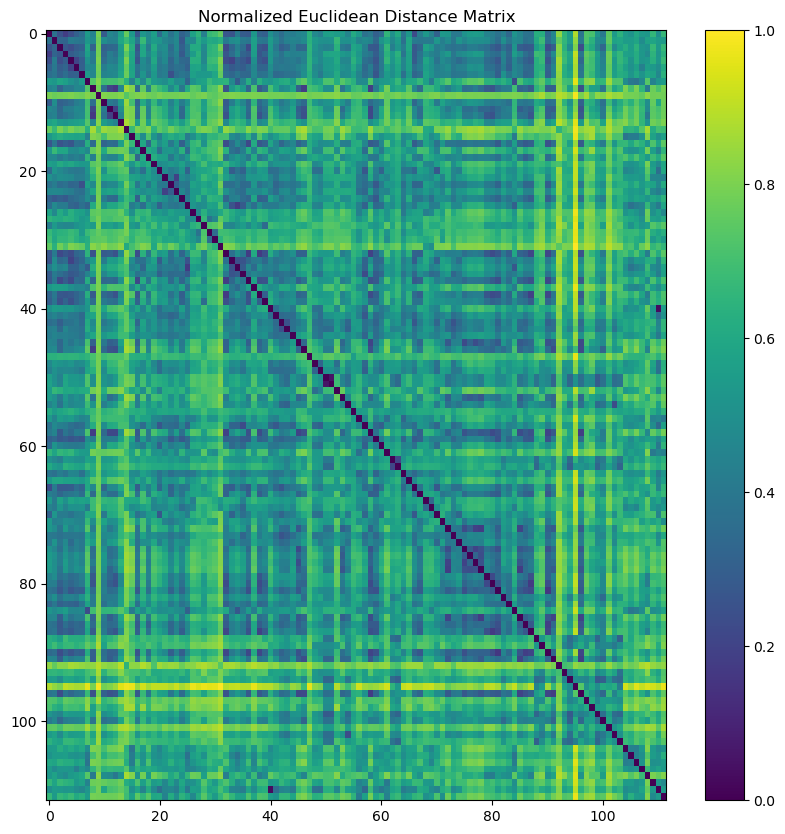

In [32]:
import matplotlib.pyplot as plt
# 绘制热力图
plt.figure(figsize=(10, 10))
plt.imshow(normalized_matrix, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Normalized Euclidean Distance Matrix')
plt.show()

In [16]:
# 保存为excel文件 方便观察
import pandas as pd

df_normalized_matrix = pd.DataFrame(normalized_matrix)
df_normalized_matrix.to_excel("normalized_distance_matrix.xlsx", index=True)

## 音色聚类

In [4]:
from sklearn.cluster import KMeans

# n_clusters = 16
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(normalized_matrix)

labels = kmeans.labels_
# 按类别划分数据
clustered_data = {}
for i in range(n_clusters):
    clustered_data[i] = []

for idx, label in enumerate(labels):
    clustered_data[label].append(idx)

# 打印每个类别的数据数量
for key in clustered_data:
    print(f"Cluster {key}: {len(clustered_data[key])} items: {','.join(map(str, clustered_data[key]))}")

Cluster 0: 13 items: 15,19,26,27,29,30,56,61,65,104,106,109,111
Cluster 1: 28 items: 0,1,2,3,4,5,6,10,16,18,22,24,32,36,38,39,42,43,59,66,67,73,74,81,83,86,87,90
Cluster 2: 11 items: 7,17,28,37,47,52,55,68,84,105,107
Cluster 3: 18 items: 20,21,23,25,33,34,35,40,41,44,48,49,57,60,64,69,70,110
Cluster 4: 12 items: 62,63,88,89,93,94,97,98,99,101,102,103
Cluster 5: 5 items: 9,14,31,92,95
Cluster 6: 10 items: 8,11,12,13,46,58,79,80,82,108
Cluster 7: 15 items: 45,50,51,53,54,71,72,75,76,77,78,85,91,96,100


# 音色是否受音高影响

In [17]:
# 制作音高wav
# instrument = 40   # 用小提琴音色
instrument = 73
notes = range(57, 69) # [A3,A4)
data[69] = 2

for i in notes:
    changeMidi('temp.mid', i, instrument)
    s.midi2audio('temp.mid', 'temp.wav')
    cutWave('temp.wav', f'midiPitch/{i}.wav', 0, 1, mono=True)

In [5]:
import torchaudio
import numpy as np
import sys
sys.path.append("../..")
from model.CQT import CQTsmall as CQT

# 创建网络
sample_rate = 22050
bins_per_octave = 36
octaves = 5
fmin = 220 / (2**(1/bins_per_octave))
cqt = CQT(
    sample_rate,
    fmin=fmin,
    octaves=octaves,
    bins_per_octave=bins_per_octave,
    hop=sample_rate//50,
    filter_scale=1.0,
    requires_grad=False
)

In [ ]:
cqts = []   # [112, 180, 51] complex
for i in notes:
    audioPath = f"midiPitch/{i}.wav"
    # 计算CQT
    waveform, sample_rate = torchaudio.load(audioPath, normalize=True)
    waveform = waveform.unsqueeze(0)                # [1,1,22050]
    cqt_data = cqt(waveform).squeeze(0).numpy()     # [2,180,51]
    complex_data = cqt_data[0] + 1j * cqt_data[1]   # [180,51]
    cqts.append(complex_data)
# 保存计算结果
cqts = np.array(cqts)
np.save(f"cqt_of_inst{instrument}_A3_A4.npy", cqts)

In [ ]:
import numpy as np
cqts = np.load(f"cqt_of_inst{instrument}_A3_A4.npy")

In [23]:
# 计算距离
import numpy as np

length = len(cqts)
aligned = []
required_octaves = bins_per_octave * octaves - len(notes) * 3

# 对能量进行归一化
for i in range(length):
	bin_offset = i * 3
	first4Octaves = cqts[i, bin_offset:bin_offset+required_octaves, :]
	aligned.append(first4Octaves / np.linalg.norm(first4Octaves))

# 计算两两之间的欧氏距离
def complex_euclidean_distance(a, b):
	return np.linalg.norm(a - b)

distance_matrix = np.zeros((length, length))

aligned = np.abs(np.array(aligned))
for i in range(length):
	for j in range(i + 1, length):
		distance_matrix[j, i] = distance_matrix[i, j] = complex_euclidean_distance(aligned[i].flatten(), aligned[j].flatten())

# 不考虑归一化
normalized_matrix = distance_matrix

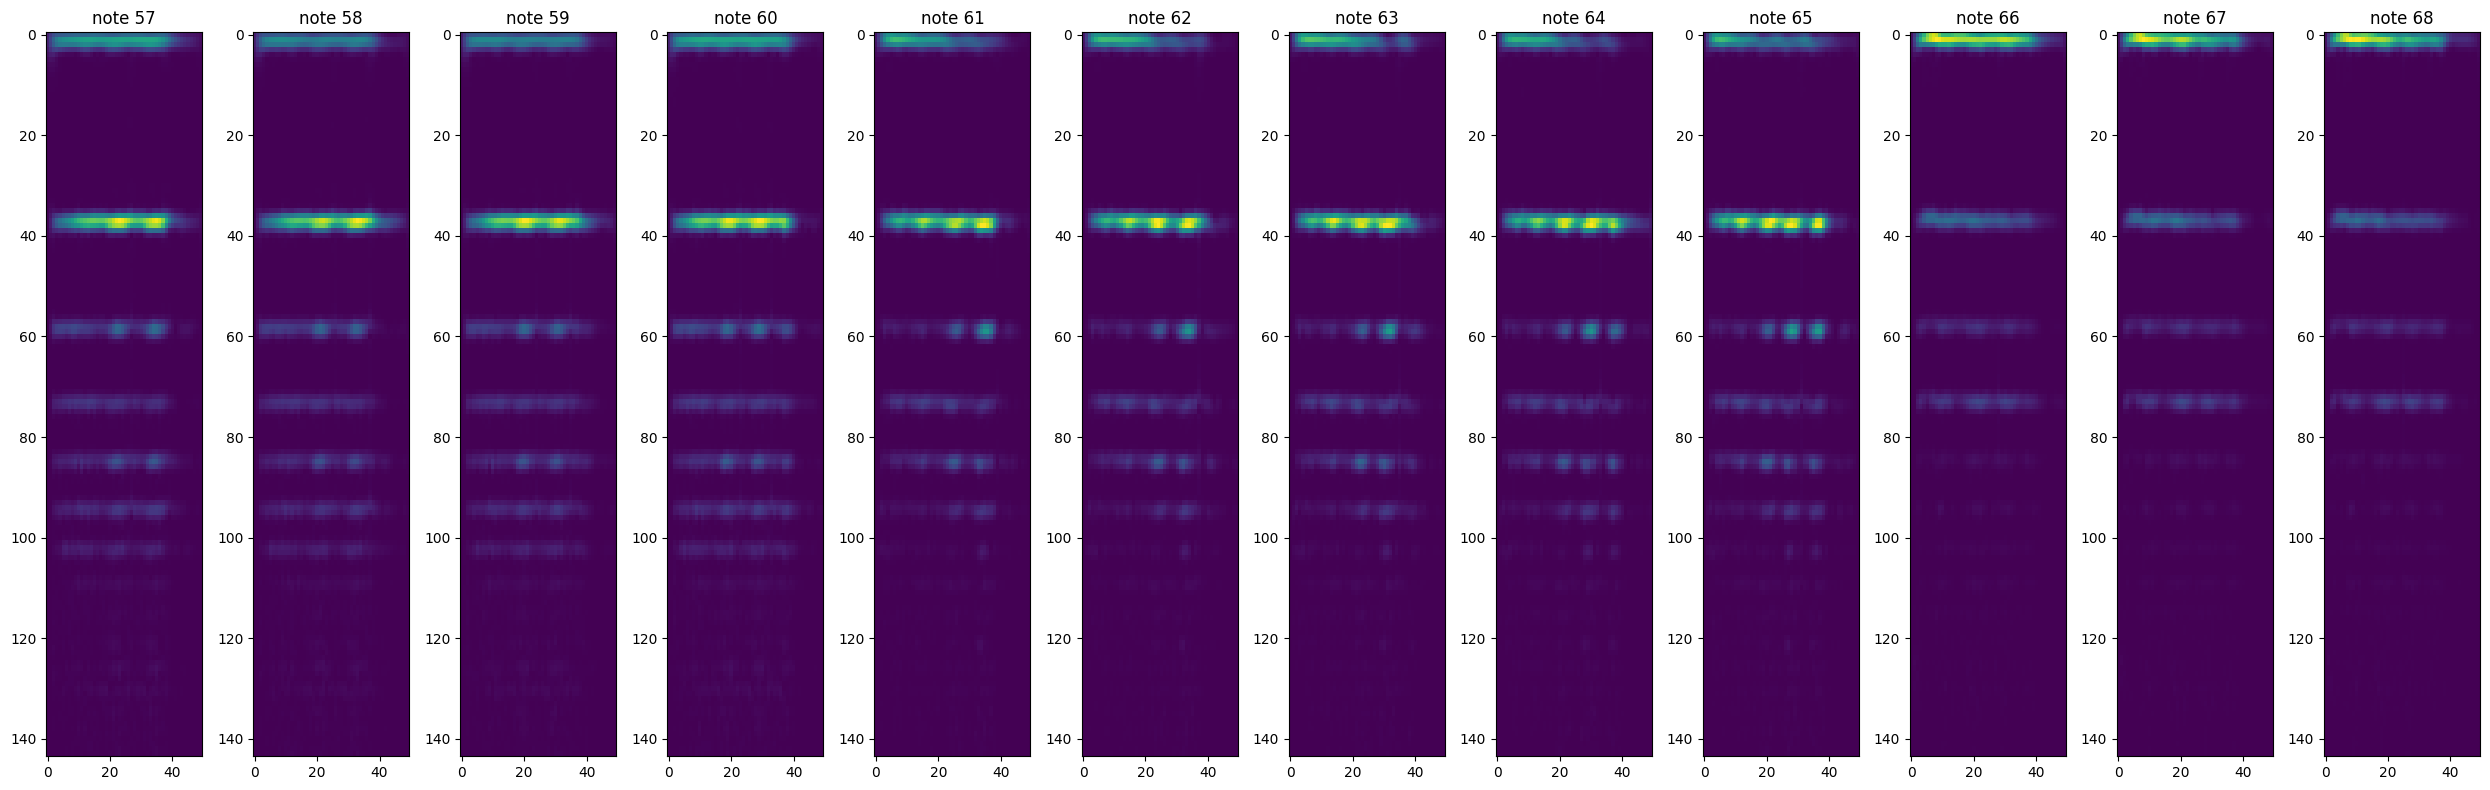

In [24]:
# 绘制aligned中每个的幅度热力图
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 8))
for idx in range(len(cqts)):
    plt.subplot(1, len(cqts), idx + 1)
    plt.imshow(aligned[idx], cmap='viridis', aspect='auto')
    plt.title(f'note {notes[idx]}')
plt.tight_layout()
plt.show()

In [95]:
# 保存为对称矩阵
np.save("normalized_distance_matrix_note.npy", normalized_matrix)

In [96]:
# 从文件读取对称矩阵
import numpy as np
normalized_matrix = np.load("normalized_distance_matrix_note.npy")

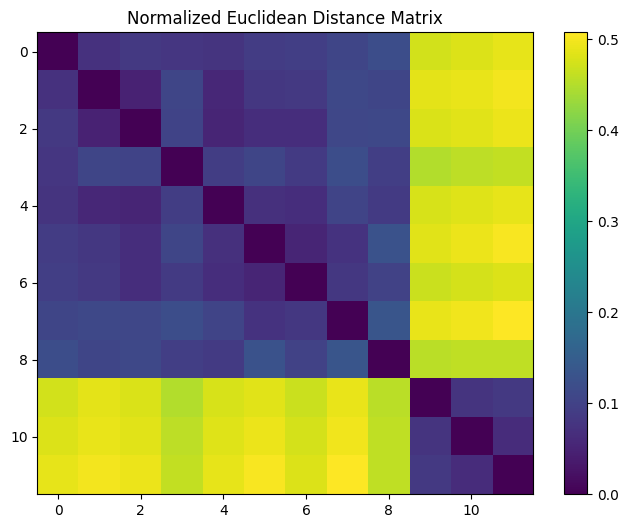

In [113]:
import matplotlib.pyplot as plt
# 绘制热力图
plt.figure(figsize=(8, 6))
plt.imshow(normalized_matrix, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Normalized Euclidean Distance Matrix')
plt.show()

In [ ]:
# 保存为excel文件 方便观察
import pandas as pd

df_normalized_matrix = pd.DataFrame(normalized_matrix)
df_normalized_matrix.to_excel("normalized_distance_matrix.xlsx", index=True)